In [46]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tflite_runtime.interpreter as tflite
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image



tf.__version__: 2.8.0
keras.__version__: 2.8.0


# 모델 변환
## 1.h5 -> pb file -> tflite
### h5 -> pb
export_path는 비어있는 폴더여야 한다. 코드 실행 후 폴더에 pb파일과 디레고리가 생성된다.

In [21]:
model_path = "C:/Users/User/Desktop/get_data/code/model/lane_navigation_final.h5"
model = keras.models.load_model(model_path, compile=False)
#model.summary()

export_path = "C:/Users/User/Desktop/get_data/code/model/tflite_model_pb"
model.save(export_path, save_format="tf")

INFO:tensorflow:Assets written to: C:/Users/User/Desktop/get_data/code/model/tflite_model_pb\assets


### pb file -> tflite file

In [32]:
saved_model_dir = "C:/Users/User/Desktop/get_data/code/model/tflite_model_pb" #'saved_model.pb가 들어있는 경로'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS] # 무슨코드일까?

tflite_model = converter.convert()

# save the model
out_model_path = 'C:/Users/User/Desktop/get_data/code/model'
open(out_model_path + '/converted_model.tflite', 'wb').write(tflite_model) # 저장할 경로
'''
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
'''

"\nwith open('model.tflite', 'wb') as f:\n  f.write(tflite_model)\n"

## 2. h5 -> tflite file

In [35]:
#keras 에서 TFlite 형식 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#저장
open(out_model_path + '/converted_model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpn17bo6q8\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpn17bo6q8\assets


1014560

In [42]:
# 양자화 모델 저장
converter = tf.lite.TFLiteConverter.from_saved_model("C:/Users/User/Desktop/get_data/code/model/tflite_model_pb")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

open('C:/Users/User/Desktop/get_data/code/model/quant.tflite', "wb").write(tflite_quant_model)

512832

## tflite 모델 details 가져오기

In [43]:
interpreter = tf.lite.Interpreter(model_path="C:/Users/User/Desktop/get_data/code/model/converted_model.tflite")

for item in interpreter.get_tensor_details():
    for key in item.keys():
        print("%s : %s" % (key, item[key]))
    print("")

name : serving_default_conv2d_input:0
index : 0
shape : [  1  66 200   3]
shape_signature : [ -1  66 200   3]
dtype : <class 'numpy.float32'>
quantization : (0.0, 0)
quantization_parameters : {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
sparsity_parameters : {}

name : dense_3/bias
index : 1
shape : [1]
shape_signature : [1]
dtype : <class 'numpy.float32'>
quantization : (0.0, 0)
quantization_parameters : {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
sparsity_parameters : {}

name : dense_2/bias
index : 2
shape : [10]
shape_signature : [10]
dtype : <class 'numpy.float32'>
quantization : (0.0, 0)
quantization_parameters : {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
sparsity_parameters : {}

name : dense_1/bias
index : 3
shape : [50]
shape_signature : [50]
dtype : <class 'numpy.float32'>
quantization : (0.0, 0)
quantiza

# Inference
## image load

image_path: C:/Users/User/Desktop/get_data/data/total_img\output (1).avi_020_095.png
steering_Angle: 95


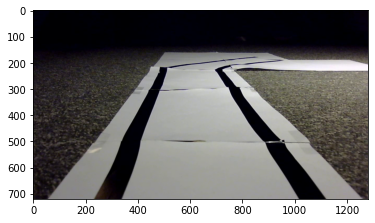

In [51]:
data_dir = 'C:/Users/User/Desktop/get_data/data/total_img'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


In [72]:
# tflite model load
interpreter = tf.lite.Interpreter(model_path="C:/Users/User/Desktop/get_data/code/model/converted_model.tflite")

In [104]:
input_details = interpreter.get_input_details()
print(input_details)

[{'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([  1,  66, 200,   3]), 'shape_signature': array([ -1,  66, 200,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [91]:
output_details = interpreter.get_output_details()

In [92]:
interpreter.allocate_tensors()

In [122]:
# input_details 'shape' 크기 맞춰야 함
img = cv2.imread(image_paths[20])
print(img.shape)
new_img = cv2.resize(img, (200, 66))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = np.expand_dims(new_img, axis=0)
print(new_img.shape)

(720, 1280, 3)
(1, 66, 200, 3)


In [121]:
# lectura y procesamiento de imagen
img = cv2.imread(image_paths[20])
new_img = cv2.resize(img, (200, 66))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = np.expand_dims(new_img, axis=0)
#print(new_img.shape)
# input_details[0]['index'] = the index which accepts the input
#print(input_details[0]['index'])
#print([new_img])
interpreter.set_tensor(input_details[0]['index'], new_img)
# realizar la prediccion del interprete
interpreter.invoke()
# output_details[0]['index'] = the index which provides the input
output_data = interpreter.get_tensor(output_details[0]['index'])
print('predict angle:',output_data)

predict angle: [[90.4459]]


image_path: C:/Users/User/Desktop/get_data/data/total_img\output (1).avi_020_095.png
steering_Angle: 95


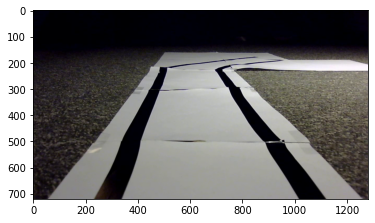

In [120]:
plt.imshow(Image.open(image_paths[20]))
print("image_path: %s" % image_paths[20] )
print("steering_Angle: %d" % steering_angles[20] )